In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1234)

# Auxiliary functions

In [2]:
def exponential_rng(lam = 1.0):  
    """ Generates exponential random number.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
    
    Returns:
        exponential random number with rate lam.
    """
    return -np.log(np.random.rand()) / lam

In [3]:
def homogeneous_poisson_process(lam, T):
    """ Generates arrivals according to a Poisson process.
    
    Keywords:
        lam (float): the rate parameter, the inverse expectation of the distribution.
        T (int): duration of the Poisson process.
    
    Returns:
        times: arrival times of a Poisson process with rate lam until time T.
    """
    times = []
    t = T - exponential_rng(lam)
    while t > 0:
        times.append(t)
        t -= exponential_rng(lam)
    return times

In [4]:
def non_homogeneous_poisson_process(lam_t, lam_max, T):
    """ Generates arrivals according to non-homogeneous Poisson process with time-dependent rate lam_t. 
    
    Keywords:
        lam_t (function handle): function returning the Poisson process rate at time t.
        lam_max (real): maximum value of lam_t(t) to be used for generating arrivals.
        T (int): duration of Poisson process.
    
    Returns:
        times: array of event times.
        efficiency (real): (0-1) efficiency of non-homogeneous Poisson process.
    """
    times = []
    n = 0 # Internal counter for the total number of events registered during the whole duration T
    t = T - exponential_rng(lam_max)
    while t > 0:
        n += 1
        # If an event occurs at time t, count it with probability p(t) = lam_t(t)/lam_max
        if np.random.rand() < lam_t(t)/lam_max:
            times.append(t)
        t -= exponential_rng(lam_max)
    return times, len(times)/n

In [5]:
def non_homogeneous_poisson_process_piecewise(lam_t, lam_max, T):
    """ Generates Business Passenger arrivals according to non-homogeneous Poisson process with time-dependent rate lam_t. 
    
    Keywords:
        lam_t (function handle): function returning the Poisson process rate at time t.
        lam_max (array): array of maximum values of lam_t(t) and cumulative durations to be used for generating arrivals.
        T (int): duration of Poisson process.

    Returns:
        times: array of event times.
        efficiency (real): (0-1) efficiency of non-homogeneous Poisson process.
    """
    times = []
    n = 0 # Internal counter for the total number of events registered during the whole duration T
    m = len(lam_max[0, :]) # Number of sub-intervals characterised by a constant lam_max
    t = T
    # Main loop
    for interval in range(m):
        done = False
        while not(done):
            # Draw an exponential random number using the maximum rate over the current sub-interval
            t = t - exponential_rng(lam_max[0, interval])
            n += 1 # Increment the counter of the generated interarrival times
            # If the next event occurs before the piecewise constant rate changes...
            if t > np.max([0, T - lam_max[1, interval]]):
                # If an event occurs at time t, count it with probability p(t) = lam_t(t)/lam_max
                if np.random.rand() < lam_t(t)/(lam_max[0, interval]): 
                    times.append(t)
            else:
                # Move to the following constant-rate interval
                t = T - lam_max[1, interval]
                done = True
                
    return times, len(times)/n

# Discrete event simulator

In [6]:
class Scenario:
    """ Airline yield management scenario.
    
    Attributes:
        days (int): planning horizon for the sale of the seat inventory.
        early (int): booking interval after which product D and H are no longer offered.
        c_business (float): ~ generation rate of business passengers.
        c_leisure  (float): ~ generation rate of leisure passengers.
        c_economy  (float): ~ generation rate of economy passengers.
        flag (boolean) : fare availability solution, if set to True only one fare at a time is offered.
        eff_sampling (boolean) : if set to True, a piecewise constant threshold is used in the sampling of the non-homogeneous Poisson process.
    """
    
    def __init__(self, 
                 days = 179,
                 early = 21,
                 c_business = 1.2,
                 c_leisure  = 0.6,
                 c_economy  = 0.8,
                 flag = False,
                 eff_sampling = True
                ):
        self.days = days
        self.early = early
        self.c_business = c_business
        self.c_leisure  = c_leisure
        self.c_economy  = c_economy
        self.flag = flag
        self.eff_sampling = eff_sampling

In [7]:
class Passenger:
    """ Generic airline passenger.
    
    Attributes:
        time (float): passenger arrival time.
        preferences (array): fare product preference weights.
    """
    def __init__(self, time):
        self.time = time
        self.preferences = []
        
    def makeChoice(self, availabilities):
        """ Select a fare product (including "no purchase") between the ones currently offered.
    
        Keywords:
            availabilities (array) : list of available tickets per each fare product
        """
        # Probability of chosing an offered available fare product
        p = (self.preferences*(availabilities > 0))/np.sum(self.preferences*(availabilities > 0))
        # Cumulative distribution function  
        csum = np.cumsum(p)
        # Draw the passenger choice by inverse transform method
        return np.min(np.where(np.random.rand() < csum))
    
    def makeIdealChoice(self):
        """ Select a fare product (including "no purchase") regardless of whether it is currently offered or not.
        """
        # Probability of chosing a fare product regardless of whether it is offered or not
        p = (self.preferences)/np.sum(self.preferences)
        # Cumulative distribution function  
        csum = np.cumsum(p)
        # Draw the passenger choice by inverse transform method
        return np.min(np.where(np.random.rand() < csum))
        
        
class Business(Passenger):
    """ Airline business passenger.
    
    Attributes:
        time (float): passenger arrival time.
        preferences (array): fare product preference weights.
    """
    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([11, 15, 18, 20, 19, 15, 12, 11, 13, 7])
        
        
class Leisure(Passenger):
    """ Airline leisure passenger.
    
    Attributes:
        time (float): passenger arrival time.
        preferences (array): fare product preference weights.
    """
    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([8, 9, 11, 12, 14, 15, 16, 18, 20, 7])
        
        
class Economy(Passenger):
    """ Airline economy passenger.
    
    Attributes:
        time (float): passenger arrival time.
        preferences (array): fare product preference weights.
    """
    def __init__(self, time):
        super().__init__(time)
        self.preferences = np.array([1, 5, 8, 10, 11, 12, 13, 15, 20, 7])

In [8]:
def totalRevenue(choices):
    """ Computes the revenue of the airline company starting from the list of passenger choices.
    """
    revenueList = [0, 1000, 900, 850, 750, 700, 650, 600, 500, 350]
    revenueList = np.flip(revenueList)
    revenue = 0
    for choice in choices:
        revenue += revenueList[choice]
        
    return revenue

In [9]:
def seatsSold(choices):
    """ Computes the number of fares sold from the list of passenger choices.
    """
    return len(choices) - np.sum(np.array(choices) == 9)

In [10]:
def simulate(scenario):
    """ Implements the simulation procedure.
    
    Keywords:
        scenario (Scenario): Airline yield management scenario.
    
    Returns:
        eff (list): Efficiency in sampling the arrival of customers.
        choices (list): Passengers choices (including "no purchase"): limited to fares currently offered. 
        idealChoices (list): Passengers choices (including "no purchase"): as if all fares were offered.
        revenue (int): Total revenue of the airline company.
        seats (int): Number of fares sold.
        arrivedLate (int): Number of passengers that arrived after the airline is fully booked.
        satisfaction (float): Percentage of time the passengers could realise their ideal choice.
    """
    # Extract information about the passenger arrival rates
    lam_business = lambda t: scenario.c_business * np.sin(t * np.pi/180)
    lam_leisure  = lambda t: scenario.c_leisure  * t / 179
    lam_economy  = lambda t: scenario.c_economy  * (1 + np.sin(t * np.pi/180 + np.pi))
    
    # Extract information about the fare products offered initially: 9 products + "no purchase" option
    if scenario.flag: # Only one fare is offered at a time: start from product I back to fare A
        availabilities = np.zeros([10])
        availabilities[8] = 20 
    else:
        availabilities = 20*np.ones([10])
    availabilities[-1] = np.Inf # In both cases there are no limits on how many times a passsnger can decide not to purchase a fare
    
    if scenario.eff_sampling:
        # Generate arrivals of business passengers
        intervals = [1/np.sqrt(2), 1, 1, 1/np.sqrt(2)]
        intervals = [scenario.c_business * i for i in intervals]
        intervals = np.array([intervals, [45, 90, 135, 180]])
        arr_business, eff_business = non_homogeneous_poisson_process_piecewise(lam_business, intervals, scenario.days)
        # Generate arrivals of leisure passengers
        intervals = [1, 0.75, 0.5, 0.25]
        intervals = [scenario.c_leisure * i for i in intervals]
        intervals = np.array([intervals, [45, 90, 135, 180]])
        arr_leisure,  eff_leisure  = non_homogeneous_poisson_process_piecewise(lam_leisure,  intervals, scenario.days)
        # Generate arrivals of economy passengers
        intervals = [1, 1 - np.sqrt(2)/2, 1 - np.sqrt(2)/2, 1]
        intervals = [scenario.c_economy * i for i in intervals]
        intervals = np.array([intervals, [45, 90, 135, 180]])
        arr_economy,  eff_economy  = non_homogeneous_poisson_process_piecewise(lam_economy,  intervals, scenario.days)
    else:
        # Generate arrivals of business passengers
        arr_business, eff_business = non_homogeneous_poisson_process(lam_business, scenario.c_business, scenario.days)
        # Generate arrivals of leisure passengers
        arr_leisure,  eff_leisure  = non_homogeneous_poisson_process(lam_leisure, scenario.c_leisure, scenario.days)
        # Generate arrivals of economy passengers
        arr_economy,  eff_economy  = non_homogeneous_poisson_process(lam_economy, scenario.c_economy, scenario.days)
    
    # Create and concatenate all the events
    events = []
    for i in range(len(arr_business)):
        events.append(Business(arr_business[i]))
    for i in range(len(arr_leisure)):
        events.append(Leisure(arr_leisure[i]))
    for i in range(len(arr_economy)):
        events.append(Economy(arr_economy[i]))
    # Sort the events by passenger arrival time
    events.sort(key = lambda event: -event.time)
  
    # Initialise the simulation 
    choices = []      # Store the passengers choice (including "no purchase"): limited to fares currently offered
    idealChoices = [] # Store the passengers choice (including "no purchase"): as if all fares were offered    
    fare_offered = -2 # Index of the fare currently offered in case only one is sold at a time (skip no purchase which is always offered)
    arrivedLate = 0   # Count the number of passengers that arrive and find no fare available
    
    # Main loop
    while len(events):
        
        # Extract the first event from the list
        e = events[0]
        t = e.time # Arrival time of the passenger: needed for early sale discount
        
        # Sample the ideal choice of the passenger
        idealChoices.append(e.makeIdealChoice())
        
        # Manage the availabilities of the fares according to the arrival time of the passenger                
        if t < 21:
            availabilities[3] = 0 # Product D is not offered when t < 21
            availabilities[7] = 0 # Product H is not offered when t < 21
            if scenario.flag and (fare_offered == 3 or fare_offered == 7):
                fare_offered -= 1
                availabilities[fare_offered] = 20
        
        # If there are no fares offered and the plain is fully booked, then the customer has arrived late
        arrivedLate += not np.any(availabilities[:-1])
        
        # Sample the choice of the passenger and decrement the availability of the chosen fare if necessary
        if availabilities[idealChoices[-1]] == 0: # The passenger could not realise his ideal choice: sample another one from the available ones
            choice = e.makeChoice(availabilities)
        else: # The passenger could realise his ideal choice
            choice = idealChoices[-1]    
        choices.append(choice)
        availabilities[choice] -= 1
        
        # If only one fare is offered at a time and its availabilities finished we move to the following product
        if scenario.flag and availabilities[fare_offered] == 0:
            if fare_offered != -10: # If there are still fares to be sold...
                fare_offered -= 1
                availabilities[fare_offered] = 20
        
        # Remove the processed event from the list
        events.pop(0)
    
    revenue = totalRevenue(choices) # Compute the revenue of the airline company starting from the list of passenger choices
    seats = seatsSold(choices)      # Compute the number of fares sold from the list of passenger choices
    satisfaction = np.sum(np.array(choices) == np.array(idealChoices))/len(choices) # Degree of satisfaction: the passenger could take his ideal choice
    eff = [eff_business, eff_leisure, eff_economy]
    
    return eff, choices, idealChoices, revenue, seats, arrivedLate, satisfaction

In [11]:
eff, choices, idealChoices, revenue, seats, arrivedLate, satisfaction = simulate(Scenario(days = 179, flag = True))

Average business passenger efficiency = 0.6392026755700357
Average leisure passenger efficiency = 0.49749809904589004
Average economy passenger efficiency = 0.36081529789664957

Average business passenger efficiency = 0.7321789464675602
Average leisure passenger efficiency = 0.7525543011633884
Average economy passenger efficiency = 0.5346217459877528


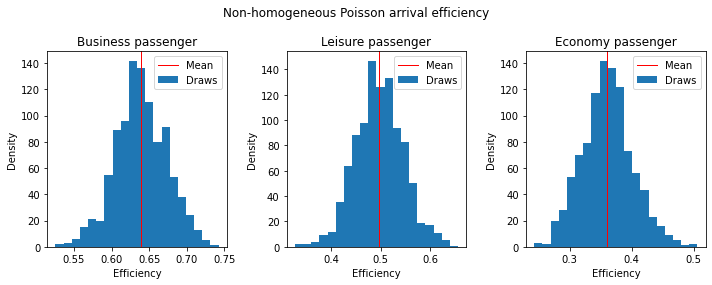

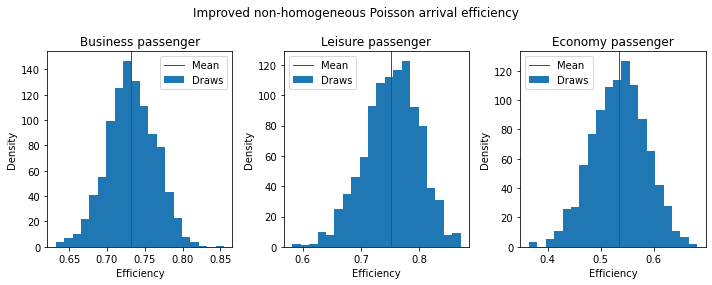

In [12]:
eff_business = []
eff_leisure  = []
eff_economy  = []
n_iter = 1000

for _ in range(n_iter):
    eff = simulate(Scenario(days = 179, eff_sampling = False))[0]
    eff_business.append(eff[0])
    eff_leisure.append(eff[1])
    eff_economy.append(eff[2])
    
fig, axs = plt.subplots(1, 3, figsize = (10, 4))
fig.suptitle('Non-homogeneous Poisson arrival efficiency')

# Plot the results using a normalized histogram
axs[0].hist(eff_business, density = False, bins = 20, label = 'Draws')
axs[0].axvline(np.mean(eff_business), color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
axs[0].set_title(f'Business passenger')

axs[1].hist(eff_leisure, density = False, bins = 20, label = 'Draws')
axs[1].axvline(np.mean(eff_leisure), color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
axs[1].set_title(f'Leisure passenger')

axs[2].hist(eff_economy, density = False, bins = 20, label = 'Draws')
axs[2].axvline(np.mean(eff_economy), color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
axs[2].set_title(f'Economy passenger')

for ax in axs.flat:
    ax.set(xlabel = 'Efficiency', ylabel = 'Density')
    ax.legend()

fig.tight_layout()

print(f'Average business passenger efficiency = {np.mean(eff_business)}')
print(f'Average leisure passenger efficiency = {np.mean(eff_leisure)}')
print(f'Average economy passenger efficiency = {np.mean(eff_economy)}\n')

# Piecewise constant threshold to increase sample efficiency
eff_business = []
eff_leisure  = []
eff_economy  = []

for _ in range(n_iter):
    eff = simulate(Scenario(days = 179, eff_sampling = True))[0]
    eff_business.append(eff[0])
    eff_leisure.append(eff[1])
    eff_economy.append(eff[2])
    
fig, axs = plt.subplots(1, 3, figsize = (10, 4))
fig.suptitle('Improved non-homogeneous Poisson arrival efficiency')

# Plot the results using a normalized histogram
axs[0].hist(eff_business, density = False, bins = 20, label = 'Draws')
axs[0].axvline(np.mean(eff_business), color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
axs[0].set_title(f'Business passenger')

axs[1].hist(eff_leisure, density = False, bins = 20, label = 'Draws')
axs[1].axvline(np.mean(eff_leisure), color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
axs[1].set_title(f'Leisure passenger')

axs[2].hist(eff_economy, density = False, bins = 20, label = 'Draws')
axs[2].axvline(np.mean(eff_economy), color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
axs[2].set_title(f'Economy passenger')

for ax in axs.flat:
    ax.set(xlabel = 'Efficiency', ylabel = 'Density')
    ax.legend()

fig.tight_layout()

print(f'Average business passenger efficiency = {np.mean(eff_business)}')
print(f'Average leisure passenger efficiency = {np.mean(eff_leisure)}')
print(f'Average economy passenger efficiency = {np.mean(eff_economy)}')

# Statistical analysis

In [13]:
onlyOneFare = False # Flag to select the first or the second scenario

In [14]:
def moving_mean_var(new_data, old_mean, old_var, t):
    """ Calculates moving sample mean and variance at time t.
    
    Keywords:
        new_data (float): new data point arriving at time t.
        old_mean (float): previous sample mean.
        old_var (float): previous sample variance.
        t (int): time index
    
    Returns:
        new_mean (float): updated sample mean.
        new_var (float): updated sample variance.
    """
    
    new_mean = old_mean + (new_data - old_mean)/(t + 1)
    new_var = (1 - 1/t)*old_var + (t + 1)*(new_mean - old_mean)**2
    
    return new_mean, new_var

In [15]:
t = 0 # Counter for the simulation runs

r_mean = 0 # Initialise the average of the revenues to 0
r_var = 0  # Initialise the variance of the revenues to 0
# Initialise empty lists that will collect: revenue during a run of the simulator, evolution of the average and variance of the revenues during the performed runs
r_list, r_mean_list, r_var_list = ([] for i in range(3)) 

s_mean = 0 # Initialise the average of the seats sold to 0
s_var = 0  # Initialise the variance of the seats sold to 0
# Initialise empty lists that will collect: seats sold during a run of the simulator, evolution of the average and variance of the seats sold during the performed runs
s_list, s_mean_list, s_var_list = ([] for i in range(3))

l_mean = 0 # Initialise the average of the late passengers to 0
l_var = 0  # Initialise the variance of the late passengers to 0
# Initialise empty lists that will collect: late passengers during a run of the simulator, evolution of the average and variance of the late passengers during the performed runs
l_list, l_mean_list, l_var_list = ([] for i in range(3)) 

sa_mean = 0 # Initialise the average of the passengers satisfaction to 0
sa_var = 0  # Initialise the variance of the passengers satisfaction to 0
# Initialise empty lists that will collect: passengers satisfaction during a run of the simulator, evolution of the average and variance of the passengers satisfaction during the performed runs
sa_list, sa_mean_list, sa_var_list = ([] for i in range(3)) 

# Stopping criterion: achieve the target precision and perform at least 100 simulation runs
precision = 0.5
done = False

# Main loop
while not(done):
    # Run the simulator
    revenue, seats, late, satisfaction = simulate(Scenario(days = 179, flag = onlyOneFare))[3:]

    # Store the values obtained during each simulation run to perform a statistical analysis 
    if t == 0:
        # We only have one sample, don't need to update the variance!
        r_mean = revenue 
        s_mean = seats
        l_mean = late
        sa_mean = satisfaction
    else:
        r_mean, r_var = moving_mean_var(revenue, r_mean, r_var, t)
        s_mean, s_var = moving_mean_var(seats, s_mean, s_var, t)
        l_mean, l_var = moving_mean_var(late, l_mean, l_var, t)
        sa_mean, sa_var = moving_mean_var(satisfaction, sa_mean, sa_var, t)
    
    r_list.append(revenue)
    r_mean_list.append(r_mean)
    r_var_list.append(r_var)
    
    s_list.append(seats)
    s_mean_list.append(s_mean)
    s_var_list.append(s_var)
    
    l_list.append(late)
    l_mean_list.append(l_mean)
    l_var_list.append(l_var)
    
    sa_list.append(satisfaction)
    sa_mean_list.append(sa_mean)
    sa_var_list.append(sa_var)
    
    t += 1
    #if np.sqrt(r_var/t) < 10 and np.sqrt(s_var/t) < precision and np.sqrt(l_var/t) < precision and t >= 100:
    if t >= 1000:
        done = True # Exit the main loop

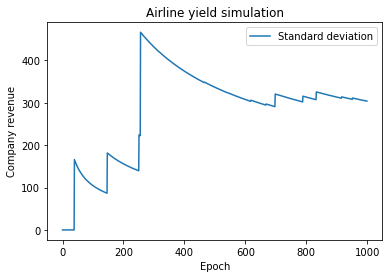

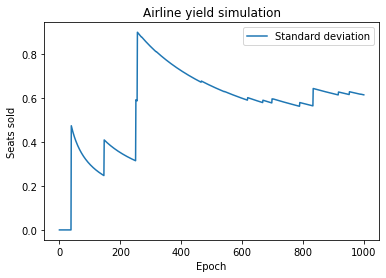

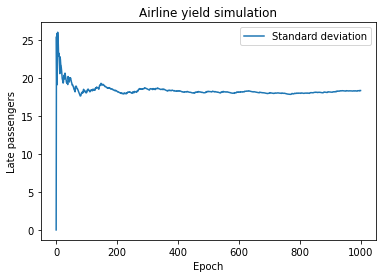

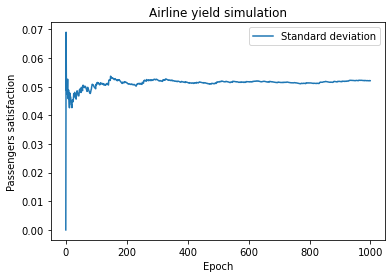

In [16]:
fig, ax = plt.subplots()

#ax.plot(r_mean_list, label = 'Mean value')
ax.plot(np.sqrt(r_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Company revenue', title = 'Airline yield simulation')
ax.legend()

plt.show()


fig, ax = plt.subplots()

#ax.plot(s_mean_list, label = 'Mean value')
ax.plot(np.sqrt(s_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Seats sold', title = 'Airline yield simulation')
ax.legend()

plt.show()


fig, ax = plt.subplots()

#ax.plot(l_mean_list, label = 'Mean value')
ax.plot(np.sqrt(l_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Late passengers', title = 'Airline yield simulation')
ax.legend()

plt.show()


fig, ax = plt.subplots()

#ax.plot(sa_mean_list, label = 'Mean value')
ax.plot(np.sqrt(sa_var_list), label = 'Standard deviation')

ax.set(xlabel = 'Epoch', ylabel = 'Passengers satisfaction', title = 'Airline yield simulation')
ax.legend()

plt.show()

In [17]:
def bootstrap(data, f_statistic, draws):
    """ Calculates the bootstrap mse of a statistic of choice
    
    Keywords:
        data (array): data array.
        f_statistic: function handle calculating the statistic of interest.
        draws (int): number of bootstrap draws.
    
    Returns:
        mse (float): mean square error of the statistic of interest.
    """
    
    theta = f_statistic(data) # Compute the desired statistic over the empirical distribution
    mse = 0 # Initialise the mean square error to 0
    for i in range(draws):
        # Randomly choose samples from the dataset and recompute the statistic of interest
        indexes = np.floor(data.shape[0]*np.random.rand(data.shape[0]))
        samples = data[np.array(indexes).astype(int)]
        # Compute the total squared error
        mse += (theta - f_statistic(samples))**2
    # Take the mean diving by the number of iterations    
    mse = mse/draws
         
    return mse

In [18]:
# Define some function handles calculating statistics of interest
f_mean = lambda data: data.mean()
f_percentile = lambda data: np.quantile(data, 0.95)
f_min = lambda data: min(data)
f_max = lambda data: max(data)

***** Statistics on the airline company revenue *****

Mean: 125970.9
Bootstrapped MSE: 102.35872999999552
Theoretical MSE:  92.32819000000003

95% percentile: 126000.0
Bootstrapped MSE: 0.0



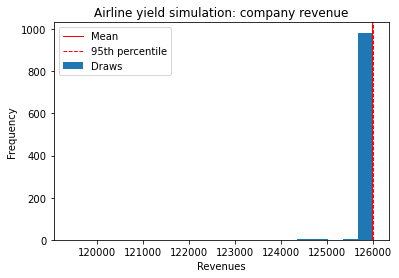


***** Statistics on the airline seats sold *****

Mean: 179.936
Bootstrapped MSE: 0.00036026000000002304
Theoretical MSE:  0.0003779040000000001

95% percentile: 180.0
Bootstrapped MSE: 0.0

Worst case: 169
Bootstrapped MSE: 3.882


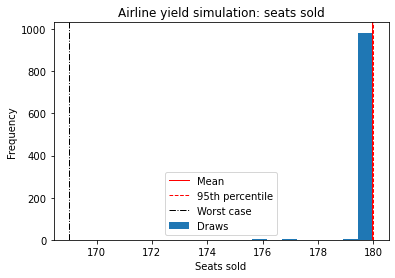


***** Statistics on the airline late passengers *****

Mean: 45.172
Bootstrapped MSE: 0.3675628499999998
Theoretical MSE:  0.33688641599999997

95% percentile: 75.04999999999995
Bootstrapped MSE: 1.4735050000000174

Worst case: 98
Bootstrapped MSE: 5.108


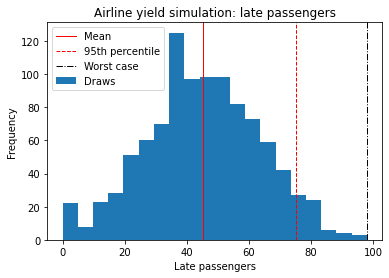


***** Statistics on the airline passengers satisfaction *****

Mean: 0.6960223918182008
Bootstrapped MSE: 2.808470614538958e-06
Theoretical MSE:  2.7138681620329562e-06

95% percentile: 0.6117110707038765
Bootstrapped MSE: 2.3286432030136777e-05

Worst case: 0.5467625899280576
Bootstrapped MSE: 5.7694918559495204e-05


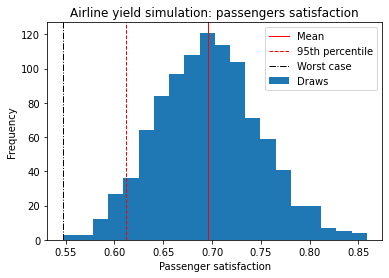

In [19]:
r_list = np.array(r_list) # For convenience
print(f'***** Statistics on the airline company revenue *****\n')

# Mean of the revenue
empirical_mean = f_mean(r_list) # Equals to r_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(r_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = r_list.var()/r_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the revenue
empirical_95p = f_percentile(-r_list)
print(f'95% percentile: {-empirical_95p}')
bootstrap_mse_95p = bootstrap(r_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

fig, ax = plt.subplots()

ax.hist(r_list, density = False, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(-empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')

ax.set(xlabel = 'Revenues', ylabel = 'Frequency', title = 'Airline yield simulation: company revenue')
ax.legend()

plt.show()


s_list = np.array(s_list) # For convenience
print(f'\n***** Statistics on the airline seats sold *****\n')

# Mean of the seats sold
empirical_mean = f_mean(s_list) # Equals to s_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(s_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = s_list.var()/s_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the seats sold
empirical_95p = f_percentile(-s_list)
print(f'95% percentile: {-empirical_95p}')
bootstrap_mse_95p = bootstrap(s_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

# Worst case of the seats sold
empirical_ws = f_min(s_list)
print(f'Worst case: {empirical_ws}')
bootstrap_mse_ws = bootstrap(s_list, f_min, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_ws}')

fig, ax = plt.subplots()

ax.hist(s_list, density = False, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(-empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')
plt.axvline(empirical_ws, color = 'k', linestyle = 'dashdot', linewidth = 1, label = 'Worst case')

ax.set(xlabel = 'Seats sold', ylabel = 'Frequency', title = 'Airline yield simulation: seats sold')
ax.legend()

plt.show()


l_list = np.array(l_list) # For convenience
print(f'\n***** Statistics on the airline late passengers *****\n')

# Mean of the seats sold
empirical_mean = f_mean(l_list) # Equals to s_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(l_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = l_list.var()/l_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the seats sold
empirical_95p = f_percentile(l_list)
print(f'95% percentile: {empirical_95p}')
bootstrap_mse_95p = bootstrap(l_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

# Worst case of the seats sold
empirical_ws = f_max(l_list)
print(f'Worst case: {empirical_ws}')
bootstrap_mse_ws = bootstrap(l_list, f_max, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_ws}')

fig, ax = plt.subplots()

ax.hist(l_list, density = False, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')
plt.axvline(empirical_ws, color = 'k', linestyle = 'dashdot', linewidth = 1, label = 'Worst case')

ax.set(xlabel = 'Late passengers', ylabel = 'Frequency', title = 'Airline yield simulation: late passengers')
ax.legend()

plt.show()


sa_list = np.array(sa_list) # For convenience
print(f'\n***** Statistics on the airline passengers satisfaction *****\n')

# Mean of the seats sold
empirical_mean = f_mean(sa_list) # Equals to s_mean up to numerical imprecisions
print(f'Mean: {empirical_mean}')
bootstrap_mse_mean = bootstrap(sa_list, f_mean, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_mean}')
mse_mean = sa_list.var()/sa_list.shape[0]
print(f'Theoretical MSE:  {mse_mean}\n')

# 95% percentile of the seats sold
empirical_95p = f_percentile(-sa_list)
print(f'95% percentile: {-empirical_95p}')
bootstrap_mse_95p = bootstrap(sa_list, f_percentile, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_95p}\n')

# Worst case of the seats sold
empirical_ws = f_min(sa_list)
print(f'Worst case: {empirical_ws}')
bootstrap_mse_ws = bootstrap(sa_list, f_min, 500)
print(f'Bootstrapped MSE: {bootstrap_mse_ws}')

fig, ax = plt.subplots()

ax.hist(sa_list, density = False, bins = 20, label = 'Draws')

plt.axvline(empirical_mean, color = 'r', linestyle = 'solid', linewidth = 1, label = 'Mean')
plt.axvline(-empirical_95p, color = 'r', linestyle = 'dashed', linewidth = 1, label = '95th percentile')
plt.axvline(empirical_ws, color = 'k', linestyle = 'dashdot', linewidth = 1, label = 'Worst case')

ax.set(xlabel = 'Passenger satisfaction', ylabel = 'Frequency', title = 'Airline yield simulation: passengers satisfaction')
ax.legend()

plt.show()